In [123]:
import torch
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from gtda.graphs import KNeighborsGraph
import itertools
from utils import GraphRNN_dataset, GraphRNN_DataSampler

from importlib import reload
import matplotlib.pyplot as plt

from preprocessor import Preprocessor
from preprocessor import draw_network
from preprocessor import get_adj_from_plot

print("Gathering data...")
flow_dataset = "../data/daily_county2county_2019_01_01.csv"
epi_dataset = "../data_epi/epidemiology.csv"
epi_dates = ["2020-06-09", "2020-06-10", "2020-06-11", "2020-06-12",
             "2020-06-13", "2020-06-14", "2020-06-15", "2020-06-16",
             "2020-06-17", "2020-06-18", "2020-06-19", "2020-06-20",
             "2020-06-21", "2020-06-22", "2020-06-23", "2020-06-24",
                "2020-06-25", "2020-06-26", "2020-06-27", "2020-06-28",
                "2020-06-29", "2020-06-30", "2020-07-01", "2020-07-02",
                "2020-07-03", "2020-07-04", "2020-07-05", "2020-07-06",
                "2020-07-07", "2020-07-08", "2020-07-09", "2020-07-10",
                "2020-07-11", "2020-07-12", "2020-07-13", "2020-07-14",
                "2020-07-15", "2020-07-16", "2020-07-17", "2020-07-18",
                "2020-07-19", "2020-07-20", "2020-07-21", "2020-07-22",
                "2020-07-23", "2020-07-24", "2020-07-25", "2020-07-26",
                "2020-07-27", "2020-07-28", "2020-07-29", "2020-07-30"
             ]

epi_dates_smaller = ["2020-06-09", "2020-06-10", "2020-06-11", "2020-06-12",
             "2020-06-13", "2020-06-14", "2020-06-15", "2020-06-16",
             "2020-06-17", "2020-06-18", "2020-06-19", "2020-06-20",
             ]

epi_dates_one_sample = ["2020-06-09", "2020-06-10", "2020-06-11", "2020-06-12",
             "2020-06-13", "2020-06-14", "2020-06-15"] # for testing
epi_dates_pred_one_sample = ["2020-06-16"] # for testing

Gathering data...


Preprocessing data...
Building the kronecker graph...
Checking that the data used to synthesize the kronecker is correct ... 
First element in the pandas dataframe:  geoid_o                 1001
geoid_d              1001021
lng_o             -86.642757
lat_o              32.534921
lng_d              63.281186
lat_d              32.847853
date_x            2019-01-01
visitor_flows       0.463154
pop_flows           0.550704
date_y            2020-06-09
new_confirmed           10.0
infection_gone           0.0
timestep                   0
Name: 0, dtype: object
Last element in the pandas dataframe:  geoid_o              10030037
geoid_d              11030065
lng_o             1390.824938
lat_o               46.381301
lng_d             1541.601912
lat_d               46.496561
date_x             2019-01-01
visitor_flows        0.109557
pop_flows            0.328222
date_y             2020-06-19
new_confirmed             0.0
infection_gone            0.0
timestep                   10
Name:

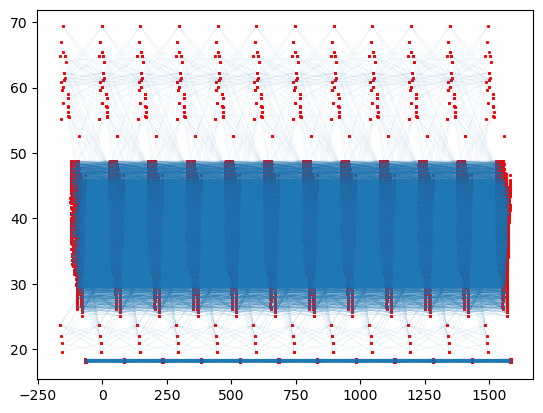

Getting the adjacency matrix..
Getting the training graph signal...
0
1
2
3
4
5
6
7
8
9
10
11
Nan value found in train_graph_sig:  2013 nan . Replacing with 0.0 ...
Nan value found in train_graph_sig:  2100 nan . Replacing with 0.0 ...
Nan value found in train_graph_sig:  31007 nan . Replacing with 0.0 ...
Nan value found in train_graph_sig:  38043 nan . Replacing with 0.0 ...
Nan value found in train_graph_sig:  48425 nan . Replacing with 0.0 ...
First few from train_graph_sig:  {1001: 10.0, 1003: 5.0, 1005: 2.0, 1007: 6.0, 1009: 2.0}
Number of nodes in the train_graph_sig:  36840
Figuring out which nodes belong to which days ...
Getting the number of nodes per day...
First day starts at:  1001
Last node in a day:  30037 : 14329
New day starts at:  1001001
Last node in a day:  1030037 : 28658
New day starts at:  2001001
Last node in a day:  2030037 : 42987
New day starts at:  3001001
Last node in a day:  3030037 : 57316
New day starts at:  4001001
Last node in a day:  4030037 : 71645


AttributeError: 'NoneType' object has no attribute 'append'

In [126]:
# THIS IS WITH THE NEW METHOD

print("Preprocessing data...")

# Use this for training to choose what size of data you want to use
cur_epi_dates = epi_dates_smaller
# cur_epi_dates = epi_dates 

# Preprocess the data
input_hor = 3   # test now with smaller input horizon
pred_hor = 1    # test now with smaller prediction horizon

print("Building the kronecker graph...")
preprocessor = Preprocessor(flow_dataset, epi_dataset, cur_epi_dates, plottable=True) # test first with epi dates smaller
graph_kronecker_whole_df = preprocessor.combined_manual_kronecker() # makes the pandas df from the kronecker data

print("Checking that the data used to synthesize the kronecker is correct ... ")
print("First element in the pandas dataframe: ", graph_kronecker_whole_df.iloc[0])
print("Last element in the pandas dataframe: ", graph_kronecker_whole_df.iloc[-1])

# if the first date is not equal to the first date in the epi_dates, then raise an error
#if graph_kronecker_whole_df["date_x"][0] != cur_epi_dates[0]:
#    raise ValueError("The first date in the pandas dataframe is not equal to the first date in the cur_epi_dates")

# if the last date is not equal to the last date in the epi_dates, then raise an error
#if graph_kronecker_whole_df["date_x"].iloc[-1] != cur_epi_dates[-1]:
#    raise ValueError("The last date in the pandas dataframe is not equal to the last date in the cur_epi_dates")

print("Drawing the network ...")
draw_network(graph_kronecker_whole_df)

print("Getting the adjacency matrix..")
adj_kronecker_whole = get_adj_from_plot(graph_kronecker_whole_df)

print("Getting the training graph signal...")
tr_epi = preprocessor.set_timestep_offset_epi_dataset(from_timestep=0).get_epi_dataset() # will get the epi info for the entire dataset, the entire kronecker, then later we index per training example and pred
train_graph_sig = {}
for data in tr_epi:
    train_graph_sig = {**train_graph_sig, **dict(zip(data.geoid_o, data.new_confirmed))}

# sort train_graph_sig by geoid_o
train_graph_sig = dict(sorted(train_graph_sig.items(), key=lambda item: item[0]))

# check if any of the values in the dictionary are Nan, if yes, print and replace with 0.0
for key, value in train_graph_sig.items():
    if np.isnan(value):
        print("Nan value found in train_graph_sig: ", key, value, ". Replacing with 0.0 ...")
        # replace NaN with 0.0
        train_graph_sig[key] = 0.0

# print("Size of train_graph_sig: ", len(train_graph_sig)) -- checked
print("First few from train_graph_sig: ", {k: train_graph_sig[k] for k in list(train_graph_sig)[:5]}) # -- checked

# how many nodes are in the train_graph_sig across the whole kronecker? This is a check
print("Number of nodes in the train_graph_sig: ", len(train_graph_sig))

# Get the training and prediction samples
# starting first with the smallest example
# how many nodes are there per day in the US?

print("Figuring out which nodes belong to which days ...")
# when the difference between the geoid_o becomes very large, then we have a new day
# we can use this to get the number of nodes per day
print("Getting the number of nodes per day...")
print("First day starts at: ", graph_kronecker_whole_df["geoid_o"][0])
last_nodes_in_a_day_list = []
for i in range(1, len(graph_kronecker_whole_df)):
    if graph_kronecker_whole_df["geoid_o"][i] - graph_kronecker_whole_df["geoid_o"][i-1] > 960000 : # in theory you should have around 3000 nodes per day
        # count how many nodes have occured between the last flag and now
        print("Last node in a day: ", graph_kronecker_whole_df["geoid_o"][i-1], ":", i)
        last_node_in_a_day = graph_kronecker_whole_df["geoid_o"][i-1]
        last_nodes_in_a_day_list.append(last_node_in_a_day)
        print("New day starts at: ", graph_kronecker_whole_df["geoid_o"][i])
        continue

# for the first 14329 edges, collect the unique geoid_o and geoid_d in one set
unique_geoids = set()

for i in range(14329):
    geoid_o = graph_kronecker_whole_df.loc[i, 'geoid_o']
    unique_geoids.add(geoid_o)

print("Number of unique geoids: ", len(unique_geoids))

# now draw out the first adjacency matrix
print("Getting the first adjacency matrix...")
adj_per_example = adj_kronecker_whole[:len(unique_geoids)*input_hor, :len(unique_geoids)*input_hor]

if adj_kronecker_whole[0, len(unique_geoids)*input_hor+1] != 0.0:
    raise ValueError("The value at adj_kronecker_whole[0, len(unique_geoids)*input_hor+1] is not equal to 0.0")


# now drawing out the first train_graph_signal
print("Getting the first train_graph_signal...")

# if the number of nodes in train_graph_sig is not equal to len(cur_epi_dates)*unique_geoids, then raise an error
if len(train_graph_sig) != len(cur_epi_dates)*len(unique_geoids):
    raise ValueError("The number of nodes in train_graph_sig is not equal to len(cur_epi_dates)*len(unique_geoids)")

# now you need to get the graph signal across the input horizon, get the first input_hor number of days
# i want a list of all the nodes in my current training example
# then i will take the training_graph_signal and isolate those parts of the dictionary and that will be my current graph signal
# cur_train_graph_sig
# from the first node until last_node_in_a_day_list[0] is the first day of nodes
# from last_node_in_a_day_list[0] until last_node_in_a_day_list[1] is the second day of nodes
# from last_node_in_a_day_list[1] until last_node_in_a_day_list[2] is the third day of nodes

print(last_nodes_in_a_day_list) # list of all the last nodes per day - ERROR: MISSING THE LARGER ONES, INSPECT DATA ABOVE
first_node = graph_kronecker_whole_df["geoid_o"][0]
node_names_by_day = np.empty(len(last_nodes_in_a_day_list), dtype=object)
print(first_node)

# start at the first node and go until you hit the last node that day, then restart the "first node" to be last+1 (name will not just numerically be +1)
for item in train_graph_sig: # for all nodes
    for day in range(len(last_nodes_in_a_day_list)):  # for all days
        if item < last_nodes_in_a_day_list[day]:
            node_names_by_day[day].append(item)

print(node_names_by_day)



In [66]:
# THIS IS THE OLD METHOD



core_nodes = []
for i in range(0, len(epi_dates_smaller) - input_hor - pred_hor):
      
      epi_dates_pred_one_sample = epi_dates_smaller[i+input_hor:i+input_hor+pred_hor]

      print("Getting the predicted graph signal..")

      pred_preproc = Preprocessor(flow_dataset, epi_dataset, epi_dates_pred_one_sample, plottable=True)
      pred_epi = pred_preproc.set_timestep_offset_epi_dataset(from_timestep=0).get_epi_dataset() #  returns a list of all the preprocessed epi datasets

      # create a dictionary where the key is the geoid_o and the value is the new_confirmed of pred_epi -- this is the output of the model
      pred_graph_sig = dict(zip(pred_epi[0].geoid_o, pred_epi[0].new_confirmed)) # RETURN THIS AS GRAPH SIGNAL OUTPUT

      if i == 0:
         core_nodes = list(pred_graph_sig.keys())
      
      # see if the pred_graph_sig keys contains all the core_nodes
      missing_nodes = set(core_nodes) - set(pred_graph_sig.keys())

      # see if core_nodes are missing nodes that other pred_graph_sig keys have
      extra_nodes = set(pred_graph_sig.keys()) - set(core_nodes)

      print("For i of ", i, " missing nodes are: ", missing_nodes, " and extra nodes are: ", extra_nodes)

Gathering data...
Getting the predicted graph signal..
0
For i of  0  missing nodes are:  set()  and extra nodes are:  set()
Getting the predicted graph signal..
0
For i of  1  missing nodes are:  set()  and extra nodes are:  set()
Getting the predicted graph signal..
0
For i of  2  missing nodes are:  set()  and extra nodes are:  {30105, 30027}
Getting the predicted graph signal..
0
For i of  3  missing nodes are:  set()  and extra nodes are:  {30027, 48461, 51021, 48435, 30105}


In [ ]:
# OLD METHOD CONTINUED 

# CREATION OF DATALOADER

# INPUT TO FUNCTION: epi_dates, input_hor, pred_hor, flow_dataset, epi_dataset, SPLIT
# OUTPUT TO FUNCTION: training_data, testing_data
nan_flag_w_matrix = 0
nan_flag_train_gr_sig = 0
nan_flag_test_gr_sig = 0

def create_dataloader(epi_dates, input_hor, pred_hor, flow_dataset, epi_dataset):
   training_data = []
   testing_data = []

   # Per input horizon and prediction horizon, we do the following:
   for i in range(0, len(epi_dates) - input_hor - pred_hor):
      
      epi_dates_one_sample = epi_dates[i:i+input_hor]
      epi_dates_pred_one_sample = epi_dates[i+input_hor:i+input_hor+pred_hor]


      print("Building the kronecker graph...")
      # Pull in the sparsified version of the graph from Victor's preprocessor.py file
      # Create a 7 day kronecker with no edge weight info or node info
      preprocessor = Preprocessor(flow_dataset, epi_dataset, epi_dates_one_sample, plottable=True)
      graph_df = preprocessor.combined_manual_kronecker()
      # draw_network(graph_df)
      print("Getting the adjacency matrix..")
      w_adj_kron = get_adj_from_plot(graph_df) # RETURN THIS FOR MODEL INPUT


      print("Getting the current training ex graph signal..")
      tr_epi = preprocessor.set_timestep_offset_epi_dataset(from_timestep=0).get_epi_dataset()

      train_graph_sig = {}
      for data in tr_epi:
         train_graph_sig = {**train_graph_sig, **dict(zip(data.geoid_o, data.new_confirmed))} # RETURN THIS AS GRAPH SIGNAL OF KRONECKER INPUT
      
      print("Getting the predicted graph signal..")
      pred_preproc = Preprocessor(flow_dataset, epi_dataset, epi_dates_pred_one_sample, plottable=True)
      pred_epi = pred_preproc.set_timestep_offset_epi_dataset(from_timestep=0).get_epi_dataset() #  returns a list of all the preprocessed epi datasets

      # create a dictionary where the key is the geoid_o and the value is the new_confirmed of pred_epi -- this is the output of the model
      pred_graph_sig = dict(zip(pred_epi[0].geoid_o, pred_epi[0].new_confirmed)) # RETURN THIS AS GRAPH SIGNAL OUTPUT

      # if the length of pred_graph_sig is not equal to number of nodes, then raise an error
      if len(pred_graph_sig) != w_adj_kron.shape[0]:
         raise ValueError("The length of the predicted graph signal is not equal to the number of nodes in the graph")

      # print(w_adj_kron, train_graph_sig, pred_graph_sig)
      training_data.append((w_adj_kron, train_graph_sig, pred_graph_sig))

   # take the last 2 entries from training_data, remove them from training_data and add them to testing_date
   testing_data = training_data[-2:]
   training_data = training_data[:-2]

   return training_data, testing_data
      
   
training_data, testing_data = create_dataloader(epi_dates, input_hor, pred_hor, flow_dataset, epi_dataset)

# store the training_data and testing_data in a pickle file
import pickle
with open("training_data.pkl", "wb") as f:
   pickle.dump(training_data, f)

with open("testing_data.pkl", "wb") as f:
   pickle.dump(testing_data, f)


# COMMENTS
# assuming the graph signal we are trying to predict is "new_confirmed"

# and where N is the timestep you want the offset to start. i.e., with 8,
# all nodes in the first dataset will be indexed 80..001, 800...002 etc, 
# and the dataset after will be 90..001, 900...002, etc
# adjacency shape is good

# adjacency is weighted which is also good



In [ ]:
# load the pickle files
import pickle
with open("training_data.pkl", "rb") as f:
   training_data = pickle.load(f)

with open("testing_data.pkl", "rb") as f:
    testing_data = pickle.load(f)

print(training_data[0][0].shape) # size of the adjacency matrix -- also the number of nodes in the kronecker
print(len(training_data[0][2])) # size of the output graph signal -- also the number of nodes in one time step of the kronecker

for i in range(len(training_data)):
    print(len(training_data[i][2])) 

orig_nodes = training_data[0][2]
diff_nodes = training_data[3][2]
# what values are in diff which are not in orig
print(set(diff_nodes.keys()) - set(orig_nodes.keys()))


In [ ]:
# THIS SHOULD BE ABLE TO REMOVE AFTER THE NEW METHOD IMPLEMENTED

# The nans are already in the training and testing graph signal -- need to remove them
print("Undergoing processing to remove nan...")

for data in training_data:
    tr_gr_sig = data[1]
    pred_gr_sig = data[2]

    # Replace nan values with 0.0 in train_graph_sig dictionary
    for key, value in tr_gr_sig.items():
        if np.isnan(value):
            tr_gr_sig[key] = 0.0

    # Replace nan values with 0.0 in pred_graph_sig dictionary
    for key, value in pred_gr_sig.items():
        if np.isnan(value):
            pred_gr_sig[key] = 0.0
    
    data = (data[0], tr_gr_sig, pred_gr_sig)

for data in testing_data:
    tr_gr_sig = data[1]
    pred_gr_sig = data[2]

    # Replace nan values with 0.0 in train_graph_sig dictionary
    for key, value in tr_gr_sig.items():
        if np.isnan(value):
            tr_gr_sig[key] = 0.0

    # Replace nan values with 0.0 in pred_graph_sig dictionary
    for key, value in pred_gr_sig.items():
        if np.isnan(value):
            pred_gr_sig[key] = 0.0
    
    data = (data[0], tr_gr_sig, pred_gr_sig)
    

# print(training_data)
# print(testing_data)

# Repeat for test_data
    

In [55]:
from torch_geometric.nn import GCNConv

In [ ]:
# make a custom subclass of Dataset (pytorch class), to the initialization of that class, feed in the traiing_data and testing_data
# inside initialization of the dataset class
# then call the method, get(), if you want to load a sample, what will it return
# at some point the data objects that you have, use the get(index), index = a single training sample (input kronecker graph, output prediction graph signal)
# then create dataloader, give it object of your dataset class 
# for data in dataloader ... loops through the data objects that you have

In [58]:
# GRAPH CONVOLUTIONAL NETWORK BASED ON KRONECKER GRAPH -- TOO MANY PARAMS NOW, TALK TO PEOPLE ABOUT THIS & HOW TO REDUCE

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv

class GraphConvolutionalNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_nodes_kron, num_nodes_pred):
        super(GraphConvolutionalNetwork, self).__init__()
        self.gconv1 = GCNConv(1, 1)
        self.gconv2 = GCNConv(1, 1) # performs graph convolutions on the kronecker graph, then you want to make output predictions
        # self.hidden_to_output = nn.Linear(1, 1)
        self.MLP = nn.Sequential( # takes in 3k^2 parameters to learn
            nn.Linear(num_nodes_kron, 10000),
            # nn.Linear((num_nodes_pred)*input_dim, num_nodes_kron),
            nn.ReLU(),
            nn.Linear(10000, num_nodes_pred*output_dim)
        )
    
    def forward(self, adj_as_edge_index, graph_signal, num_nodes_pred):
        x, edge_index = graph_signal, adj_as_edge_index
        # print(x, edge_index)
        x = x.reshape(1, x.shape[0], x.shape[1])
        x = self.gconv1(x, edge_index)
        # print(x)
        x = torch.relu(x)
        x = self.gconv2(x, edge_index)
        # print(x)
        x = torch.relu(x)
        x = x[-num_nodes_pred:]
        # print(x)
        # print(x.shape)
        x = x.view(x.shape[1])
        # take the output of the kronecker graph convolutions and make predictions
        # only take the last nodes from the final layer to make predictions?
        # x = self.hidden_to_output(x)
        x = self.MLP(x)
        # print(x)
        return x

# Define the model
input_dim = 1  # Number of features per node
hidden_dim = 16  # Embedding dimension
output_dim = 1  # Number of output features per node
num_nodes_kron = training_data[0][0].shape[0]
num_nodes_pred = len(training_data[0][2])

print(num_nodes_kron)
print(num_nodes_pred)

model = GraphConvolutionalNetwork(input_dim, hidden_dim, output_dim, num_nodes_kron, num_nodes_pred)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters:", num_params)

# Define the loss function and optimizer
num_epochs = 3
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses = []

# Train the model
# if you do it manually, you need to add shuffling

# batching is not really needed due to nature of graphs, already in "batches"
cont_count_pred_sig = 0
cont_count_kron_sig = 0
cont_count_adj = 0
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    for data in training_data:
        adjacency, graph_signal, target_graph_signal = data
        # print(adjacency.shape, len(graph_signal), len(target_graph_signal))

        # if the target_graph_signal is not the correct shape, then continue
        if len(target_graph_signal) != num_nodes_pred:
            # print(len(target_graph_signal))
            cont_count_pred_sig += 1
            continue
        
        if len(graph_signal) != num_nodes_kron:
            cont_count_kron_sig += 1
            continue

        if adjacency.shape[0] != num_nodes_kron:
            cont_count_adj += 1
            continue
        
        # Ensure graph_signal is of shape [number_of_nodes, input_dim]
        graph_signal = torch.tensor(list(graph_signal.values()), dtype=torch.float32).view(-1, input_dim)

        # turn target graph signal into the correct shape
        target_graph_signal = torch.tensor(list(target_graph_signal.values()), dtype=torch.float32).view(-1, output_dim)

        # Convert adjacency to edge_index
        adj_as_edge_index = torch.tensor(adjacency.nonzero(), dtype=torch.long)
        # print(adj_as_edge_index.shape)
        
        output = model(adj_as_edge_index, graph_signal, num_nodes_pred)
        # print(output.shape, target_graph_signal.shape)
        # print(output)
        # print(target_graph_signal)
        loss = criterion(output, target_graph_signal)
        loss.backward()
        # print("current loss: ", loss.item())
        optimizer.step()
        train_losses.append(loss.item())
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}')

# Test the model
model.eval()
test_loss = 0.0
predictions = []
targets = []
with torch.no_grad():
    for data in testing_data:
        adjacency, graph_signal, target_graph_signal = data
        # print(adjacency.shape, len(graph_signal), len(target_graph_signal))

        # if the target_graph_signal is not the correct shape, then continue
        if len(target_graph_signal) != num_nodes_pred:
            cont_count_pred_sig += 1
            continue
        
        if len(graph_signal) != num_nodes_kron:
            cont_count_kron_sig += 1
            continue

        if adjacency.shape[0] != num_nodes_kron:
            cont_count_adj += 1
            continue
        
        # Ensure graph_signal is of shape [number_of_nodes, input_dim]
        graph_signal = torch.tensor(list(graph_signal.values()), dtype=torch.float32).view(-1, input_dim)

        # turn target graph signal into the correct shape
        target_graph_signal = torch.tensor(list(target_graph_signal.values()), dtype=torch.float32).view(-1, output_dim)

        # Convert adjacency to edge_index
        adj_as_edge_index = torch.tensor(adjacency.nonzero(), dtype=torch.long)

        out = model(adj_as_edge_index, graph_signal, num_nodes_pred)
        loss = criterion(out, target_graph_signal)
        test_loss += loss.item()
    test_loss /= len(testing_data)

# Compute metrics
print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.4f}')

print("continue count: ", cont_count_pred_sig, cont_count_kron_sig, cont_count_adj)


21490
3086
Number of parameters: 245773090
Epoch 1/3, Train Loss: 2318.1851
Epoch 2/3, Train Loss: 2312.6309
Epoch 3/3, Train Loss: 2302.7834
Epoch 3/3, Test Loss: 0.0000
continue count:  122 3 0
